## Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import networkx as nx
import cirq

## 1. Create a Random Max-Cut graph
Generate a random Erdös Renyi graph with 5 nodes and 0.5 edge probability.

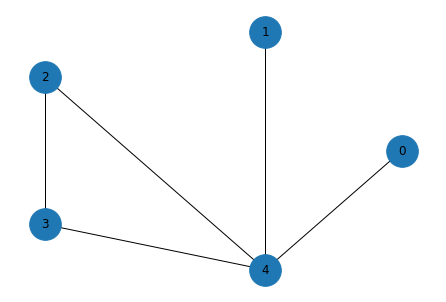

In [2]:
graph = nx.generators.random_graphs.erdos_renyi_graph(n=5,p=0.5)
nx.draw_circular(graph, node_size=1000, with_labels=True)
plt.show()

Create the corresponding Max-Cut Hamiltonian where each edge has unit weight.
$$
    H_C = - \frac{1}{2} \sum_{\langle i, j\rangle} (1 - Z_i Z_j ).
$$
*Note* that since $H_C$ is diagonal in the computational basis we can store it as an 1-D array.

In [3]:
def product(*args, repeat=1):
    # product('ABCD', 'xy') --> Ax Ay Bx By Cx Cy Dx Dy
    # product(range(2), repeat=3) --> 000 001 010 011 100 101 110 111
    pools = [list(pool) for pool in args] * repeat
    result = [[]]
    for pool in pools:
        result = [x+[y] for x in result for y in pool]
    for prod in result:
        yield list(prod)
        
# Number of edges
M = len(graph.edges)
# Number of nodes
N = len(graph.nodes)
# Adjacency matrix
A = nx.adjacency_matrix(graph).todense()

# Generate a list of all possible n‐tuples of elements from {1,-1} and
# organize them as a (2^N x N) matrix. In other words create all possible
# solutions to the problem.
s = np.array(list(product([1, -1], repeat=N)))

# Construct the the cost function for Max Cut: C = 1/2 Sum(Z_i*Z_j) - M/2
# Note: This is the minimization version
C = 1/2*(np.diag(s@np.triu(A)@s.T) - M)

## 2. Construct the QAOA circuit
Now that we have created a Max-Cut problem graph, it's time to generate the QAOA circuit. For simplicity we only create the $p=1$ circuit

In [5]:
# Symbols for the rotation angles in the QAOA circuit.
alpha = sp.Symbol('alpha')
beta = sp.Symbol('beta')

def qaoa_circuit(graph:object, with_noise:object=None):
    """
    Creates the QAOA circuit given a graph
    """
    num_q = len(graph.nodes) # number of qubits
    qubits = cirq.LineQubit.range(num_q)
    
    """Here we create the circuit"""
    circuit = cirq.Circuit() # Initialize circuit
    circuit.append(cirq.H(q) for q in qubits) # Add Hadamard
    
    if with_noise != None:
        circuit.append(with_noise.on_each(*cirq.LineQubit.range(num_q))) # Add noise
    
    for (u,v) in graph.edges: 
        circuit.append(
            # This gate is equivalent to the RZZ-gate
            cirq.ops.ZZPowGate(
                exponent=(alpha / np.pi),
                global_shift=-.5)(qubits[u], qubits[v])
        )
        if with_noise != None:
            circuit.append(with_noise.on_each(qubits[u], qubits[v])) # Add noise
                
    circuit.append(
        cirq.Moment(
            # This gate is equivalent to the RX-gate
            # That is why we multiply by two in the exponent
            cirq.ops.XPowGate(
                exponent=(2 * beta / np.pi),
                global_shift=-.5)(q) for q in qubits
        )
    )

    if with_noise != None:
        # Append a depolarzing channel after the RX-gate.
        # Make the error probability 10 times smaller than the error rate
        # for two qubit gates
        circuit.append(DepolarizingChannel(
                p=with_noise._p / 10).on_each(*qubits))
    return circuit

Look at the circuit

In [6]:
qaoa_circuit(graph)

┌────────────────────────────────────────────────────────┐
0: ───H────ZZ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X^(0.636619772367581*beta)───
           │
1: ───H────┼───────────────────────────────────────────────────────────ZZ───────────────────────────────────────────────────────────────────────────────────────────X^(0.636619772367581*beta)───
           │                                                           │
2: ───H────┼───────────────────────────ZZ──────────────────────────────┼──────────────────────────────ZZ────────────────────────────────────────────────────────────X^(0.636619772367581*beta)───
           │                           │                               │                              │
3: ───H────┼───────────────────────────ZZ^(0.318309886183791*alpha)────┼──────────────────────────────┼──────────────────────────────ZZ─────────────────────────────X^(0.636619772367581*beta)───
           │                                                           │                              │                              │
4: ───H────ZZ^(0.318309886183791*alpha)────────────────────────────────ZZ^(0.318309886183791*alpha)───ZZ^(0.318309886183791*alpha)───ZZ^(0.318309886183791*alpha)───X^(0.636619772367581*beta)───
          └────────────────────────────────────────────────────────┘

### Error models

To simulate QAOA with noise we begin by constructing the noise channels

#### Depolarizing Channel
$$
\Lambda_\mathrm{dep}(\rho) = (1-\frac{4\epsilon}{3})\rho + \frac{\epsilon}{4}(X\rho X + Y\rho Y + Z\rho Z)
$$

#### Dephasing Channel
$$
\Lambda_\mathrm{Z}(\rho) = (1-\frac{\epsilon}{2})\rho + \frac{\epsilon}{2}Z\rho Z
$$

In [7]:
"""Create a Depolarizing channel."""
class DepolarizingChannel(cirq.SingleQubitGate):
    def __init__(self, p: float) -> None:
        self._p = p

    def _mixture_(self):
        ps = [1.0 - self._p, self._p/3, self._p/3, self._p/3]
        ops = [cirq.unitary(cirq.I), cirq.unitary(cirq.X), cirq.unitary(cirq.Y), cirq.unitary(cirq.Z)]
        return tuple(zip(ps, ops))

    def _has_mixture_(self) -> bool:
        return True

    def _circuit_diagram_info_(self, args) -> str:
        return f"Lambda_Dep({self._p})"

"""Create a Dephasing channel."""
class DephasingChannel(cirq.SingleQubitGate):
    def __init__(self, p: float) -> None:
        self._p = p

    def _mixture_(self):
        ps = [1.0 - self._p, self._p]
        ops = [cirq.unitary(cirq.I), cirq.unitary(cirq.Z)]
        return tuple(zip(ps, ops))

    def _has_mixture_(self) -> bool:
        return True

    def _circuit_diagram_info_(self, args) -> str:
        return f"Lambda_Z({self._p})"

Then we can input the channels with argument `with_noise` to `qaoa_circuit`

In [8]:
# Add noise to the circuit.
qaoa_circuit(graph, with_noise=DephasingChannel(p=0.01))

┌────────────────────────────────────────────────────────┐
0: ───H───Lambda_Z(0.01)────ZZ──────────────────────────────────────────────────────────Lambda_Z(0.01)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X^(0.636619772367581*beta)───Lambda_Dep(0.001)───
                            │
1: ───H───Lambda_Z(0.01)────┼────────────────────────────────────────────────────────────────────────────ZZ─────────────────────────────Lambda_Z(0.01)───────────────────────────────────────────────────────────────────────────────────────────────────X^(0.636619772367581*beta)───Lambda_Dep(0.001)───
                            │                                                                            │
2: ───H───Lambda_Z(0.01)────┼───────────────────────────ZZ──────────────────────────────Lambda_Z(0.01)───┼───────────────────────────────────────────────ZZ─────────────────────────────Lambda_Z(0.01)───────────────────────────────────────────────────X^(0.636619772367581*beta)───Lambda_Dep(0.001)───
                            │                           │                                                │                                               │
3: ───H───Lambda_Z(0.01)────┼───────────────────────────ZZ^(0.318309886183791*alpha)────Lambda_Z(0.01)───┼───────────────────────────────────────────────┼───────────────────────────────────────────────ZZ─────────────────────────────Lambda_Z(0.01)───X^(0.636619772367581*beta)───Lambda_Dep(0.001)───
                            │                                                                            │                                               │                                               │
4: ───H───Lambda_Z(0.01)────ZZ^(0.318309886183791*alpha)────────────────────────────────Lambda_Z(0.01)───ZZ^(0.318309886183791*alpha)───Lambda_Z(0.01)───ZZ^(0.318309886183791*alpha)───Lambda_Z(0.01)───ZZ^(0.318309886183791*alpha)───Lambda_Z(0.01)───X^(0.636619772367581*beta)───Lambda_Dep(0.001)───
                           └────────────────────────────────────────────────────────┘

## 3. Calculating the expected value of the QAOA cost Hamiltonian

We calculate the expectation value using $\mathrm{Tr}(H_C\rho)$.

In [9]:
"""Simulating with the density matrix simulator."""
sim = cirq.DensityMatrixSimulator(
    split_untangled_states = True
)

num_q = len(graph.nodes) # number of qubits
# initial state 
initial_state = np.zeros(2**num_q) 
initial_state[0] = 1

alpha_value = np.random.rand() * np.pi
beta_value = np.random.rand() * np.pi 
resolver = cirq.ParamResolver({'alpha': alpha_value, 'beta': beta_value})
result = sim.simulate(
    qaoa_circuit(graph, with_noise=DepolarizingChannel(p=0.01)),
    resolver,
    initial_state=initial_state,
    qubit_order=cirq.LineQubit.range(num_q)
) 

"""Output from simulator."""
rho = result.final_density_matrix # final state

"""Expectation value"""
print(f'Alpha = {round(alpha_value, 3)} Beta = {round(beta_value, 3)}')
print(f'Computed Cost: {round(np.trace(np.diag(C)@rho).real,4)}')

Alpha = 1.795 Beta = 0.66
Computed Cost: -1.9412


## 4. Outer loop optimization

Now that we can compute the cost function, we want to find the optimal cost. To do this we use a minimizer from the `scipy` library.

In [10]:
from scipy.optimize import basinhopping
from scipy.optimize import minimize

We start by defining an objective function

In [11]:
def func(x0):
    alpha_value, beta_value = x0
    sim = cirq.DensityMatrixSimulator(
        split_untangled_states = True
    )
    circuit = qaoa_circuit(
        graph,
        meas=False,
        with_noise=DepolarizingChannel(p=0.01)
    )
    
    resolver = cirq.ParamResolver({'alpha': alpha_value, 'beta': beta_value})
    result = sim.simulate(
        circuit,
        resolver,
        initial_state=initial_state,
        qubit_order=cirq.LineQubit.range(num_q)
    )
    rho = result.final_density_matrix # final state
    return np.trace(np.diag(C)@rho).real

Next we can input our objective function to a minimizer

In [12]:
%%script false --no-raise-error

x0 = [np.pi/4,np.pi/4]
res = basinhopping(
    func, 
    x0,
    niter=50,
    T=1.0, 
    stepsize=0.5
)

and look at the output from the minimizer

In [13]:
%%script false --no-raise-error
res

## 5. Virtual Distillation
Once we found have the optimal angles we can use virtual distillation to retrive a better cost value / approximation ratio. For simplicity we create the $M=2$ circuit. The mitigated cost is
$$
\langle H_C\rangle_\mathrm{mitigated} = \frac{\mathrm{Tr}(H_C\rho^2)}{\mathrm{Tr}(\rho^2)}.
$$

In [14]:
def virtual_distillation(rho:np.array, meas:bool=True, with_noise:object=None):
    shape = rho.shape
    num_q = int(np.log2(shape[0])) # number of qubits in rho
    qubits = cirq.LineQubit.range(2*num_q+1) # Create qubits
    
    """Create the virtual distillation circuit."""
    circuit = cirq.Circuit() # Initialize circuit
            
    for q in range(num_q):
        circuit.append(cirq.FREDKIN(qubits[0], qubits[q+1], qubits[num_q+(q+1)]))
        if with_noise != None:
            circuit.append(with_noise.on_each(qubits[0], qubits[q+1], qubits[num_q+(q+1)]))
    return circuit

Display the circuit

In [15]:
virtual_distillation(rho,with_noise=DepolarizingChannel(p=0.1))

0: ────@───Lambda_Dep(0.1)───@───Lambda_Dep(0.1)───@───Lambda_Dep(0.1)───@───Lambda_Dep(0.1)───@───Lambda_Dep(0.1)───
       │                     │                     │                     │                     │
1: ────×───Lambda_Dep(0.1)───┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────────────
       │                     │                     │                     │                     │
2: ────┼─────────────────────×───Lambda_Dep(0.1)───┼─────────────────────┼─────────────────────┼─────────────────────
       │                     │                     │                     │                     │
3: ────┼─────────────────────┼─────────────────────×───Lambda_Dep(0.1)───┼─────────────────────┼─────────────────────
       │                     │                     │                     │                     │
4: ────┼─────────────────────┼─────────────────────┼─────────────────────×───Lambda_Dep(0.1)───┼─────────────────────
       │                     │                     │                     │                     │
5: ────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────────────×───Lambda_Dep(0.1)───
       │                     │                     │                     │                     │
6: ────×───Lambda_Dep(0.1)───┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────────────
                             │                     │                     │                     │
7: ──────────────────────────×───Lambda_Dep(0.1)───┼─────────────────────┼─────────────────────┼─────────────────────
                                                   │                     │                     │
8: ────────────────────────────────────────────────×───Lambda_Dep(0.1)───┼─────────────────────┼─────────────────────
                                                                         │                     │
9: ──────────────────────────────────────────────────────────────────────×───Lambda_Dep(0.1)───┼─────────────────────
                                                                                               │
10: ───────────────────────────────────────────────────────────────────────────────────────────×───Lambda_Dep(0.1)───

Next we simulate the circuit. We call the output $\rho_\mathrm{out}$

In [16]:
"""Setup variables"""
rho_sq = rho@rho # square of rho
shape = rho.shape # shape of rho
num_q = int(np.log2(shape[0])) # number of qubits in rho

"""Prepare the initial state of the ancilla"""
ancilla = 1/2*np.array([[1,1],[1,1]])

"""Prepare the total initial state"""
initial_state = cirq.kron(ancilla,rho,rho)

"""Change data type to complex64"""
initial_state = initial_state.astype('complex64')

"""Simulating with the density matrix simulator."""
simulator = cirq.DensityMatrixSimulator(
    split_untangled_states=True
)

"""Create the virtial distillation circuit"""
vd_circuit = virtual_distillation(
    rho,
    with_noise=DepolarizingChannel(p=0.1)
)

"""Simulate the circuit"""
qubits = cirq.LineQubit.range(2*num_q+1) # Create qubits
result = simulator.simulate(
    vd_circuit,
    initial_state=initial_state,
    qubit_order=qubits
)
# output density matrix
rho_out = result.final_density_matrix

We create the measurment operators

In [17]:
""""Symmeterized version of the cost Hamiltonian H_C"""
C_2 = 0 
for (u,v) in graph.edges: 
    C_2 += 1/4 * (1-cirq.PauliString(cirq.Z(qubits[u+1])) * cirq.PauliString(cirq.Z(qubits[v+1]))) \
         + 1/4 * (1-cirq.PauliString(cirq.Z(qubits[u+(num_q+1)])) * cirq.PauliString(cirq.Z(qubits[v+(num_q+1)])))
    
"""Ancilla Observable"""
X_0 = cirq.PauliString(cirq.X(qubits[0]))

We can now compute
$$
\langle H_C\rangle_\mathrm{mitigated} = \frac{\mathrm{Tr}(X_0 H_C^{(2)}\rho_\mathrm{out})}{\mathrm{Tr}(X_0\rho_\mathrm{out})}
$$

In [18]:
y = X_0 * C_2 # observable numerator
numerator = y.expectation_from_density_matrix(
    state=rho_out, 
    qubit_map={q: i for i, q in enumerate(qubits)}
).real

denominator = X_0.expectation_from_density_matrix(
    state=rho_out, 
    qubit_map={q: i for i, q in enumerate(qubits)}
).real

mitigated_cost = (numerator / denominator)
print('Mitigated cost', round(mitigated_cost,5))

Mitigated cost 2.03839


We can compare the mitigated cost to the predicted which is the following for a depolarizing channel

$$
\langle H_C\rangle_\mathrm{mitigated} = \frac{1}{2}\sum_{\langle i,j\rangle}\left((1-\epsilon)^2\frac{\mathrm{Tr}(Z_iZ_j\rho^2)}{\mathrm{Tr}(\rho^2)} -1\right) 
$$
*Note* for the dephasing channel $\epsilon=0$.

In [21]:
rho_sq = rho@rho / np.trace(rho@rho)
epsilon = 0.1 # probability of error
_qubits = cirq.LineQubit.range(len(graph.nodes))
expval = 0 
for u, v in graph.edges:
    zz = cirq.PauliString(cirq.Z(_qubits[u])) * cirq.PauliString(cirq.Z(_qubits[v]))
    expval_zz = zz.expectation_from_density_matrix(
        state=rho_sq, 
        qubit_map={q: i for i, q in enumerate(_qubits)}
    ).real
    expval += (1-4*epsilon/3)**2 * expval_zz
    
mitigated_cost_predicted = - 1/2 * (expval - M)
print('Predicted mitigated cost', round(mitigated_cost_predicted,5))

Predicted mitigated cost 2.03839


We see that they are equivalent

### 5.1 Variance of estimator
The variance of the estimator is given by
$$
\newcommand{\Var}[]{\mathrm{Var}}
\newcommand{\expval}[1]{\langle #1 \rangle }
\newcommand{\Cov}[]{\mathrm{Cov}}
\Var(\mathrm{Estimator})\approx 
    \frac{1}{R}\Bigg(\frac{\Var(H_C^{(2)}X^\mathbf{0})}{\expval{X^\mathbf{0}}^2} + \frac{\expval{H_C^{(2)}X^\mathbf{0}}^2}{\expval{X^\mathbf{0}}^4}\Var(X^\mathbf{0}) - 2\frac{\expval{H_C^{(2)}X^\mathbf{0}}}{\expval{X^\mathbf{0}}^3}\Cov(H_C^{(2)}X^\mathbf{0},X^\mathbf{0})\Bigg)
$$ 
where $R$ is the number of samples.

We therefore need to calculate the values of the five terms

1. $\expval{H_C^{(2)}X^\mathbf{0}}$
2. $\expval{X^\mathbf{0}}$
3. $\Var(H_C^{(2)}X^\mathbf{0})$
4. $\Var(X^\mathbf{0})$
5. $\Cov(O^{(2)}X^\mathbf{0},X^\mathbf{0})$

The **first** term is
$
\expval{H_C^{(2)}X^\mathbf{0}}
$

In [22]:
numerator

0.7588240890181623

The **second** term is
$
\expval{X^\mathbf{0}}
$

In [23]:
denominator

0.3722667098045349

The **third** term is 
$
\Var(H_C^{2}X^\mathbf{0}) 
= \expval{(H_C^{(2)}X^\mathbf{0})^2} - \expval{H_C^{(2)}X^\mathbf{0}}
= \expval{(H_C^{(2)})^2} - \expval{H_C^{(2)}X^\mathbf{0}}
$

In [24]:
y = C_2*C_2
var_numerator = y.expectation_from_density_matrix(
    state=rho_out, 
    qubit_map={q: i for i, q in enumerate(qubits)}
).real - numerator**2

The **fourth** term is $\Var(X^\mathbf{0}) = \expval{(X^\mathbf{0})^2} - \expval{X^\mathbf{0}}^2 = 1 - \expval{X^\mathbf{0}}^2$

In [25]:
var_denominator = 1 - denominator**2

The **fifth** term is $\Cov(O^{(2)}X^\mathbf{0},X^\mathbf{0}) = \expval{H_C^{(2)}(X^\mathbf{0})^2} - \expval{H_C^{(2)}X^\mathbf{0}}\expval{X^\mathbf{0}} = \expval{H_C^{(2)}} - \expval{H_C^{(2)}X^\mathbf{0}}\expval{X^\mathbf{0}}$ 

In [26]:
cov = (C_2).expectation_from_density_matrix(
    state=rho_out, 
    qubit_map={q: i for i, q in enumerate(qubits)}
).real - numerator*denominator

The variance of the estimator can now be calculated

In [27]:
var_estimator = (var_numerator / denominator**2 \
               + numerator**2 / denominator**4 * var_denominator \
               - 2 * numerator / denominator**3 * cov)
print("The variance is {0} for epsilon = {1}".format(round(var_estimator.real,8), epsilon))

The variance is 5.48508876 for epsilon = 0.1


The number of measurments required to be below `threshold` is  

In [28]:
threshold = 1e-3
R = var_estimator / threshold
print("Number of measurments is {0} to have the variance below {1}".format(int(np.ceil(R)), threshold))

Number of measurments is 5486 to have the variance below 0.001


The variance of the unmitigated expectation value would be 
$\Var(\bar X) = \frac{1}{R} \sigma^2$
with $\sigma^2 = \expval{H_C^2} - \expval{H_C}^2$

In [29]:
var_cost = np.trace(np.diag(C)@np.diag(C)@rho).real - np.trace(np.diag(C)@rho).real**2
R = var_cost / threshold
print("Number of measurments is {0} to have the variance below {1}".format(int(np.ceil(R)), threshold))

Number of measurments is 1506 to have the variance below 0.001


### Version

In [30]:
import platform
print("python:",platform.python_version())
print('cirq:',cirq.__version__)
print('numpy:',np.__version__)
print('sympy:',sp.__version__)
print('networkx:',nx.__version__)

python: 3.9.14
cirq: 0.13.1
numpy: 1.21.5
sympy: 1.9
networkx: 2.6.3
